In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from numpy import absolute
from numpy import mean, std
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data.csv')
data.drop(columns=['Unnamed: 0'], inplace= True)

In [3]:
len(data)

209

In [4]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close_x', 'Volume', 'Close_y', 'roe',
       'debtToEquity', 'ev/ebitda', 'eps', 'gdp', 'infl', 'dateStr',
       'reddit_sentiment', 'twitter_sentiment'],
      dtype='object')

### Training Data Preparation

In [5]:
# convert data to training data
def series_to_supervised(data, target, quarterly, n_in=1, n_out=1, dropnan=True):    
    df = data.loc[:, list(pd.Series(data.columns).apply(lambda x: x not in  quarterly)) ].copy()
    n_vars = df.shape[1]
    df_quarterly = data.loc[:, list(pd.Series(data.columns).apply(lambda x: x in  quarterly))].copy()
    
    quarterly_dict= {}
    for col in quarterly:
        quarterly_dict[col] = []
        
    for i in range(len(df_quarterly)):
        for col, arr in quarterly_dict.items():
            temp = 0
            if i < n_in - 1:
                arr.append(None)
            else:
                
                for j in range(n_in):
                    temp += float(df_quarterly.iloc[i - j][col])       
                arr.append(temp / n_in)

    for col in quarterly:
        df_quarterly[col] = quarterly_dict[col]
        
    
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        if i == 1: 
          names += [ df.columns[j] + '(t)' for j in range(n_vars)]
        else:
          names += [ df.columns[j] +('(t-%d)' % (i-1)) for j in range(n_vars)]
    
    cols.append(df_quarterly.shift(n_in))
    names += list(df_quarterly.columns)
    
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[target].shift(-i))
        names += [ target + ('%d(t+%d)' % (1, i+1))]
        

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Feature Importance 

In [6]:
score_df = pd.DataFrame(columns=['vars', 'mae', 'mse', 'rmse'])

### input = 10, ouput = 1

### Time Series Preprocessing

In [7]:
final_data = data.copy().drop(columns=['Date', 'dateStr'])
train_df = series_to_supervised(final_data, 'Close_x',['roe', 'debtToEquity', 'ev/ebitda', 'eps', 'gdp', 'infl'], 10, 1)

In [8]:
train_df.columns

Index(['Open(t-9)', 'High(t-9)', 'Low(t-9)', 'Close_x(t-9)', 'Volume(t-9)',
       'Close_y(t-9)', 'reddit_sentiment(t-9)', 'twitter_sentiment(t-9)',
       'Open(t-8)', 'High(t-8)', 'Low(t-8)', 'Close_x(t-8)', 'Volume(t-8)',
       'Close_y(t-8)', 'reddit_sentiment(t-8)', 'twitter_sentiment(t-8)',
       'Open(t-7)', 'High(t-7)', 'Low(t-7)', 'Close_x(t-7)', 'Volume(t-7)',
       'Close_y(t-7)', 'reddit_sentiment(t-7)', 'twitter_sentiment(t-7)',
       'Open(t-6)', 'High(t-6)', 'Low(t-6)', 'Close_x(t-6)', 'Volume(t-6)',
       'Close_y(t-6)', 'reddit_sentiment(t-6)', 'twitter_sentiment(t-6)',
       'Open(t-5)', 'High(t-5)', 'Low(t-5)', 'Close_x(t-5)', 'Volume(t-5)',
       'Close_y(t-5)', 'reddit_sentiment(t-5)', 'twitter_sentiment(t-5)',
       'Open(t-4)', 'High(t-4)', 'Low(t-4)', 'Close_x(t-4)', 'Volume(t-4)',
       'Close_y(t-4)', 'reddit_sentiment(t-4)', 'twitter_sentiment(t-4)',
       'Open(t-3)', 'High(t-3)', 'Low(t-3)', 'Close_x(t-3)', 'Volume(t-3)',
       'Close_y(t-3)', '

In [9]:
cols_series = ['Open', 'High', 'Low', 'Close_x', 'Close_y', 'Volume', 'reddit_sentiment', 'twitter_sentiment']
cols_unival = ['roe', 'debtToEquity','ev/ebitda', 'eps', 'gdp', 'infl', 'Close_x1(t+1)']

In [10]:
col_order = []
cur = pd.Series(train_df.columns)

for col in cols_series:
    filtered = list(cur[cur.str.startswith(col)])
    if (col == 'Close_x'):
        filtered.remove('Close_x1(t+1)')
    col_order.extend(filtered)

col_order.extend(cols_unival)

In [11]:
col_order

['Open(t-9)',
 'Open(t-8)',
 'Open(t-7)',
 'Open(t-6)',
 'Open(t-5)',
 'Open(t-4)',
 'Open(t-3)',
 'Open(t-2)',
 'Open(t-1)',
 'Open(t)',
 'High(t-9)',
 'High(t-8)',
 'High(t-7)',
 'High(t-6)',
 'High(t-5)',
 'High(t-4)',
 'High(t-3)',
 'High(t-2)',
 'High(t-1)',
 'High(t)',
 'Low(t-9)',
 'Low(t-8)',
 'Low(t-7)',
 'Low(t-6)',
 'Low(t-5)',
 'Low(t-4)',
 'Low(t-3)',
 'Low(t-2)',
 'Low(t-1)',
 'Low(t)',
 'Close_x(t-9)',
 'Close_x(t-8)',
 'Close_x(t-7)',
 'Close_x(t-6)',
 'Close_x(t-5)',
 'Close_x(t-4)',
 'Close_x(t-3)',
 'Close_x(t-2)',
 'Close_x(t-1)',
 'Close_x(t)',
 'Close_y(t-9)',
 'Close_y(t-8)',
 'Close_y(t-7)',
 'Close_y(t-6)',
 'Close_y(t-5)',
 'Close_y(t-4)',
 'Close_y(t-3)',
 'Close_y(t-2)',
 'Close_y(t-1)',
 'Close_y(t)',
 'Volume(t-9)',
 'Volume(t-8)',
 'Volume(t-7)',
 'Volume(t-6)',
 'Volume(t-5)',
 'Volume(t-4)',
 'Volume(t-3)',
 'Volume(t-2)',
 'Volume(t-1)',
 'Volume(t)',
 'reddit_sentiment(t-9)',
 'reddit_sentiment(t-8)',
 'reddit_sentiment(t-7)',
 'reddit_sentiment(t-6)'

In [12]:
train_df = train_df[col_order]

In [13]:
train_scaled = train_df.copy()
train_scaled = train_scaled.reset_index().drop('index', axis=1)

In [14]:
train_scaled.columns

Index(['Open(t-9)', 'Open(t-8)', 'Open(t-7)', 'Open(t-6)', 'Open(t-5)',
       'Open(t-4)', 'Open(t-3)', 'Open(t-2)', 'Open(t-1)', 'Open(t)',
       'High(t-9)', 'High(t-8)', 'High(t-7)', 'High(t-6)', 'High(t-5)',
       'High(t-4)', 'High(t-3)', 'High(t-2)', 'High(t-1)', 'High(t)',
       'Low(t-9)', 'Low(t-8)', 'Low(t-7)', 'Low(t-6)', 'Low(t-5)', 'Low(t-4)',
       'Low(t-3)', 'Low(t-2)', 'Low(t-1)', 'Low(t)', 'Close_x(t-9)',
       'Close_x(t-8)', 'Close_x(t-7)', 'Close_x(t-6)', 'Close_x(t-5)',
       'Close_x(t-4)', 'Close_x(t-3)', 'Close_x(t-2)', 'Close_x(t-1)',
       'Close_x(t)', 'Close_y(t-9)', 'Close_y(t-8)', 'Close_y(t-7)',
       'Close_y(t-6)', 'Close_y(t-5)', 'Close_y(t-4)', 'Close_y(t-3)',
       'Close_y(t-2)', 'Close_y(t-1)', 'Close_y(t)', 'Volume(t-9)',
       'Volume(t-8)', 'Volume(t-7)', 'Volume(t-6)', 'Volume(t-5)',
       'Volume(t-4)', 'Volume(t-3)', 'Volume(t-2)', 'Volume(t-1)', 'Volume(t)',
       'reddit_sentiment(t-9)', 'reddit_sentiment(t-8)',
       'reddit

In [15]:
trform_list = {}

In [16]:
def minmaxscaler(index, row, in_size, num_var):
    trform_dict = {}
    trformed_row = []
    value = 0
    for i in range(num_var):
        cur = np.array(row[ i*in_size : (i+1)*in_size ])
        rowmaxmin = cur.max() - cur.min()
        print('rowmaxmin', rowmaxmin)
        rowmin = cur.min()
        print('rowmin', rowmin)
        trform_dict[i] = [rowmaxmin, rowmin]
        trform_list[index] = trform_dict
        cur = [ (x - rowmin) / (rowmaxmin) for x in cur]
        trformed_row.extend(cur)
        if (i == 3):
            target = row[-1]
            value = (target - rowmin) / rowmaxmin
    
    rest = np.array(row[ num_var*in_size : -1 ])
    trformed_row.extend(rest)
    trformed_row.append(value)
    return trformed_row
            

In [17]:
for index, row in train_scaled.iterrows():
    trformed_row = minmaxscaler(index, row, 10, 6)
    train_scaled.loc[index] = trformed_row

rowmaxmin 7.244257091803064
rowmin 42.57033562947372
rowmaxmin 8.75650956968451
rowmin 43.33976471682615
rowmaxmin 7.892708436968526
rowmin 41.01211656853789
rowmaxmin 7.157157897949219
rowmin 43.28653335571289
rowmaxmin 159.72998046875
rowmin 2783.300048828125
rowmaxmin 406921200.0
rowmin 392954000.0
rowmaxmin 6.261909363216844
rowmin 43.55268335805994
rowmaxmin 6.513552112941412
rowmin 45.58272217356925
rowmaxmin 5.504577220641828
rowmin 43.40024778486459
rowmaxmin 5.972751617431641
rowmin 44.47093963623047
rowmaxmin 144.669921875
rowmin 2798.360107421875
rowmaxmin 406921200.0
rowmin 392954000.0
rowmaxmin 4.826296855036929
rowmin 44.98829586623985
rowmaxmin 6.432741368297322
rowmin 45.66353291821334
rowmaxmin 5.716353320909185
rowmin 43.18847168459723
rowmaxmin 6.9734649658203125
rowmin 43.4702262878418
rowmaxmin 144.669921875
rowmin 2798.360107421875
rowmaxmin 406921200.0
rowmin 392954000.0
rowmaxmin 6.356505066725624
rowmin 43.45808765455116
rowmaxmin 8.232558823152822
rowmin 43.86

rowmin 66.38022650885655
rowmaxmin 20.107795840149137
rowmin 67.09109905746928
rowmaxmin 18.11698296184929
rowmin 63.48773796451495
rowmaxmin 17.32270050048828
rowmin 66.98078918457031
rowmaxmin 470.760009765625
rowmin 2761.6298828125
rowmaxmin 457254800.0
rowmin 397726400.0
rowmaxmin 18.661809563117984
rowmin 67.72352060381006
rowmaxmin 18.60338265085383
rowmin 69.748267035045
rowmaxmin 19.664810669899126
rowmin 65.06389770258842
rowmaxmin 20.32379150390625
rowmin 67.88284301757812
rowmaxmin 409.22998046875
rowmin 2823.159912109375
rowmaxmin 457254800.0
rowmin 397726400.0
rowmaxmin 21.744015982825218
rowmin 67.72352060381006
rowmaxmin 21.778990412714478
rowmin 69.748267035045
rowmaxmin 21.277190602191624
rowmin 65.06389770258842
rowmaxmin 19.509437561035156
rowmin 69.41244506835938
rowmaxmin 389.64990234375
rowmin 2842.739990234375
rowmaxmin 480477600.0
rowmin 397726400.0
rowmaxmin 19.586902713868056
rowmin 69.88063387276722
rowmaxmin 19.07014101773771
rowmin 73.29279680129649
rowmaxm

rowmaxmin 197.22998046875
rowmin 3773.860107421875
rowmaxmin 427279500.0
rowmin 274245900.0
rowmaxmin 24.066075755936637
rowmin 117.61425401531174
rowmaxmin 19.84582704725598
rowmin 122.52514195972007
rowmaxmin 17.27209635119162
rowmin 114.8277957778998
rowmaxmin 20.1037139892578
rowmin 114.97601318359376
rowmaxmin 304.0498046875
rowmin 3773.860107421875
rowmaxmin 427279500.0
rowmin 274245900.0
rowmaxmin 17.380781425482198
rowmin 117.61425401531174
rowmaxmin 13.714916677132337
rowmin 122.52514195972007
rowmaxmin 17.27209635119162
rowmin 114.8277957778998
rowmaxmin 20.1037139892578
rowmin 114.97601318359376
rowmaxmin 306.64013671875
rowmin 3821.35009765625
rowmaxmin 427279500.0
rowmin 274245900.0
rowmaxmin 17.380781425482198
rowmin 117.61425401531174
rowmaxmin 13.714916677132337
rowmin 122.52514195972007
rowmaxmin 17.27209635119162
rowmin 114.8277957778998
rowmaxmin 18.7838897705078
rowmin 114.97601318359376
rowmaxmin 341.90966796875
rowmin 3821.35009765625
rowmaxmin 427279500.0
rowmin 

rowmaxmin 26.43984178604427
rowmin 149.99139258232748
rowmaxmin 16.102453008989983
rowmin 162.4260703735068
rowmaxmin 21.708492508672805
rowmin 149.19621570320402
rowmaxmin 27.652496337890625
rowmin 149.71307373046875
rowmaxmin 591.400146484375
rowmin 3991.239990234375
rowmaxmin 281213400.0
rowmin 294237400.0
rowmaxmin 26.43984178604427
rowmin 149.99139258232748
rowmaxmin 22.503371009480333
rowmin 156.02515237301645
rowmaxmin 32.737738283640084
rowmin 138.16696992823674
rowmaxmin 32.489349365234375
rowmin 144.876220703125
rowmaxmin 591.400146484375
rowmin 3991.239990234375
rowmaxmin 347055800.0
rowmin 294237400.0
rowmaxmin 28.25016887624497
rowmin 148.18106549212678
rowmaxmin 29.441604661159914
rowmin 149.08691872133687
rowmaxmin 38.899528144807704
rowmin 132.00518006706912
rowmaxmin 34.90827941894531
rowmin 142.45729064941406
rowmaxmin 608.89013671875
rowmin 3973.75
rowmaxmin 347055800.0
rowmin 294237400.0
rowmaxmin 36.263444692609085
rowmin 140.16778967576266
rowmaxmin 29.53119296696

In [18]:
trform_list

{0: {0: [7.244257091803064, 42.57033562947372],
  1: [8.75650956968451, 43.33976471682615],
  2: [7.892708436968526, 41.01211656853789],
  3: [7.157157897949219, 43.28653335571289],
  4: [159.72998046875, 2783.300048828125],
  5: [406921200.0, 392954000.0]},
 1: {0: [6.261909363216844, 43.55268335805994],
  1: [6.513552112941412, 45.58272217356925],
  2: [5.504577220641828, 43.40024778486459],
  3: [5.972751617431641, 44.47093963623047],
  4: [144.669921875, 2798.360107421875],
  5: [406921200.0, 392954000.0]},
 2: {0: [4.826296855036929, 44.98829586623985],
  1: [6.432741368297322, 45.66353291821334],
  2: [5.716353320909185, 43.18847168459723],
  3: [6.9734649658203125, 43.4702262878418],
  4: [144.669921875, 2798.360107421875],
  5: [406921200.0, 392954000.0]},
 3: {0: [6.356505066725624, 43.45808765455116],
  1: [8.232558823152822, 43.86371546335784],
  2: [7.547744487171499, 41.35708051833492],
  3: [8.350650787353516, 42.093040466308594],
  4: [198.580078125, 2744.449951171875],


In [19]:
train_scaled.columns

Index(['Open(t-9)', 'Open(t-8)', 'Open(t-7)', 'Open(t-6)', 'Open(t-5)',
       'Open(t-4)', 'Open(t-3)', 'Open(t-2)', 'Open(t-1)', 'Open(t)',
       'High(t-9)', 'High(t-8)', 'High(t-7)', 'High(t-6)', 'High(t-5)',
       'High(t-4)', 'High(t-3)', 'High(t-2)', 'High(t-1)', 'High(t)',
       'Low(t-9)', 'Low(t-8)', 'Low(t-7)', 'Low(t-6)', 'Low(t-5)', 'Low(t-4)',
       'Low(t-3)', 'Low(t-2)', 'Low(t-1)', 'Low(t)', 'Close_x(t-9)',
       'Close_x(t-8)', 'Close_x(t-7)', 'Close_x(t-6)', 'Close_x(t-5)',
       'Close_x(t-4)', 'Close_x(t-3)', 'Close_x(t-2)', 'Close_x(t-1)',
       'Close_x(t)', 'Close_y(t-9)', 'Close_y(t-8)', 'Close_y(t-7)',
       'Close_y(t-6)', 'Close_y(t-5)', 'Close_y(t-4)', 'Close_y(t-3)',
       'Close_y(t-2)', 'Close_y(t-1)', 'Close_y(t)', 'Volume(t-9)',
       'Volume(t-8)', 'Volume(t-7)', 'Volume(t-6)', 'Volume(t-5)',
       'Volume(t-4)', 'Volume(t-3)', 'Volume(t-2)', 'Volume(t-1)', 'Volume(t)',
       'reddit_sentiment(t-9)', 'reddit_sentiment(t-8)',
       'reddit

### Coefficient as Feature Importance

In [20]:
x = train_scaled.drop('Close_x1(t+1)', axis=1)
y = train_scaled['Close_x1(t+1)']

In [21]:
# Take last 50 days as test data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=88, shuffle=False)

In [22]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [23]:
from sklearn.linear_model import LinearRegression

best_model = LinearRegression().fit(X_train, y_train)

In [24]:
pred = best_model.predict(X_test)
pred_trformed = [pred[x - y_test.index[0]] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]
y_trformed =  [y[x] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]

mae = mean_absolute_error(y_trformed, pred_trformed)
mse = mean_squared_error(y_trformed, pred_trformed)
rmse = mean_squared_error(y_trformed, pred_trformed, squared=False)
r2 = r2_score(y_trformed, pred_trformed)
score_df.loc[len(score_df)] = ['past10_LR', mae, mse, rmse]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)    

Mean Absolute Error: 13.32325843605122
Mean Squared Error: 252.08741445795872
Root Mean Squared Error: 15.877260924289136
R-squared: -0.654882418460496


<AxesSubplot:>

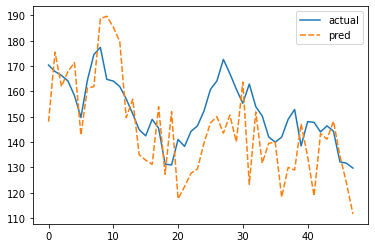

In [25]:
output = pd.DataFrame({'actual': np.array(y_trformed), 'pred': np.array(pred_trformed)})

sns.lineplot(data=output)

Feature: Open(t-9), Score: 0.6147428998
Feature: Open(t-8), Score: 0.7378399446
Feature: Open(t-7), Score: 0.0649439358
Feature: Open(t-6), Score: 0.8914899950
Feature: Open(t-5), Score: -0.2844202140
Feature: Open(t-4), Score: 0.4186967569
Feature: Open(t-3), Score: -0.0742353356
Feature: Open(t-2), Score: -0.5178515149
Feature: Open(t-1), Score: -0.0521254831
Feature: Open(t), Score: -0.1271710432
Feature: High(t-9), Score: -0.4318736748
Feature: High(t-8), Score: 0.1611071537
Feature: High(t-7), Score: -0.4599968164
Feature: High(t-6), Score: -0.3478633838
Feature: High(t-5), Score: -0.0650647222
Feature: High(t-4), Score: -0.3476461617
Feature: High(t-3), Score: -0.1603097870
Feature: High(t-2), Score: 0.3908720213
Feature: High(t-1), Score: -0.3121247082
Feature: High(t), Score: -0.3728604904
Feature: Low(t-9), Score: -0.2645791605
Feature: Low(t-8), Score: 0.1854452842
Feature: Low(t-7), Score: 0.1871158498
Feature: Low(t-6), Score: 0.1829279282
Feature: Low(t-5), Score: 0.481327

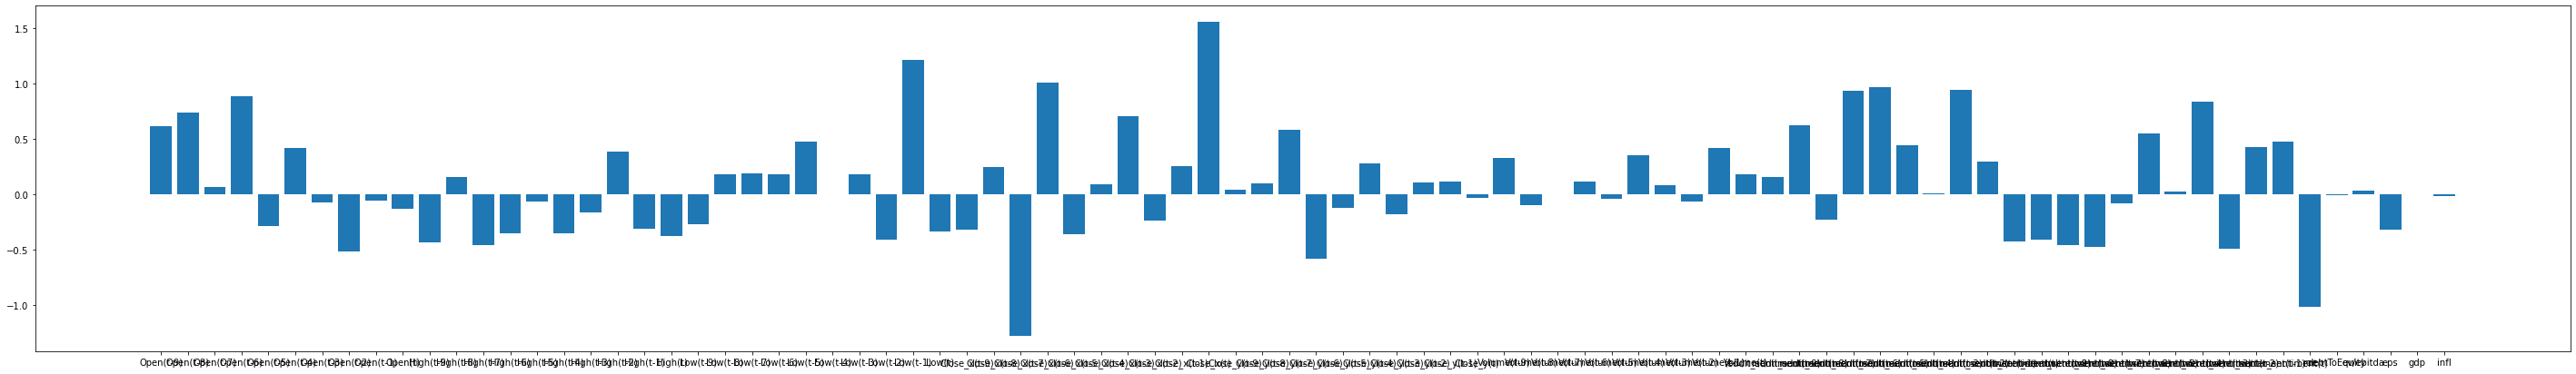

In [26]:
# get importance
importance = best_model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print(f'Feature: {col_order[i]}, Score: {v:.10f}')
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([col_order[x] for x in range(len(importance))], importance)
plt.show()

### Input : 5 Output : 1

### Coefficient as Feature Importance

In [27]:
final_data = data.copy().drop(columns=['Date', 'dateStr'])
train_df = series_to_supervised(final_data, 'Close_x',['roe', 'debtToEquity', 'ev/ebitda', 'eps', 'gdp', 'infl'], 5, 1)

In [28]:
cols_series = ['Open', 'High', 'Low', 'Close_x', 'Close_y', 'Volume', 'reddit_sentiment', 'twitter_sentiment']
cols_unival = ['roe', 'debtToEquity','ev/ebitda', 'eps', 'gdp', 'infl', 'Close_x1(t+1)']

In [29]:
col_order = []
cur = pd.Series(train_df.columns)

for col in cols_series:
    filtered = list(cur[cur.str.startswith(col)])
    if (col == 'Close_x'):
        filtered.remove('Close_x1(t+1)')
    col_order.extend(filtered)

col_order.extend(cols_unival)

In [30]:
train_df = train_df[col_order]

In [31]:
train_scaled = train_df.copy()
train_scaled = train_scaled.reset_index().drop('index', axis=1)

In [32]:
trform_list = {}

In [33]:
for index, row in train_scaled.iterrows():
    trformed_row = minmaxscaler(index, row, 5, 6)
    train_scaled.loc[index] = trformed_row

rowmaxmin 4.386064540289063
rowmin 37.64469606162858
rowmaxmin 1.6509073098462892
rowmin 41.3573674483082
rowmaxmin 4.664523327624657
rowmin 37.12911445141811
rowmaxmin 1.7284507751464915
rowmin 40.82010269165039
rowmaxmin 86.31005859375
rowmin 2709.800048828125
rowmaxmin 465456000.0
rowmin 364944800.0
rowmaxmin 1.5074149251371196
rowmin 41.0629207043366
rowmaxmin 1.6066106471714363
rowmin 41.73315406965472
rowmaxmin 1.2168690971266471
rowmin 40.57676868191612
rowmaxmin 2.4664306640625
rowmin 40.82010269165039
rowmaxmin 86.31005859375
rowmin 2709.800048828125
rowmaxmin 198640400.0
rowmin 364944800.0
rowmaxmin 2.4897626537233393
rowmin 41.0629207043366
rowmaxmin 3.8495681039145353
rowmin 41.73315406965472
rowmaxmin 2.417165600310426
rowmin 40.98308218455416
rowmaxmin 4.258480072021477
rowmin 41.23471832275391
rowmaxmin 57.33984375
rowmin 2775.60009765625
rowmaxmin 244424400.0
rowmin 364944800.0
rowmaxmin 4.510127095347919
rowmin 41.0629207043366
rowmaxmin 5.279559964746284
rowmin 42.553

rowmaxmin 7.578480571429083
rowmin 68.1207342060696
rowmaxmin 8.493087768554688
rowmin 69.45106506347656
rowmaxmin 108.330078125
rowmin 3221.2900390625
rowmaxmin 271125600.0
rowmin 431980400.0
rowmaxmin 7.94773042684389
rowmin 69.61980080827865
rowmaxmin 7.179852129528655
rowmin 71.88918737252476
rowmaxmin 6.512257699270009
rowmin 69.18695707822867
rowmaxmin 6.654106140136719
rowmin 71.29004669189453
rowmaxmin 108.330078125
rowmin 3221.2900390625
rowmaxmin 241256000.0
rowmin 431980400.0
rowmaxmin 6.666318444894685
rowmin 70.90121279022786
rowmaxmin 6.663875870686397
rowmin 73.51052162900112
rowmaxmin 4.898266732645055
rowmin 70.80094804485363
rowmaxmin 4.6292724609375
rowmin 73.31488037109375
rowmaxmin 85.990234375
rowmin 3243.6298828125
rowmaxmin 377587200.0
rowmin 500996000.0
rowmaxmin 4.242858485161506
rowmin 73.32467274996104
rowmaxmin 2.6361944252829375
rowmin 77.53820307440458
rowmaxmin 4.027667269578387
rowmin 72.66929125208206
rowmaxmin 3.1521987915039062
rowmin 75.481559753417

rowmin 101.5465178631465
rowmaxmin 14.104240417480455
rowmin 108.42134857177734
rowmaxmin 253.159912109375
rowmin 3281.06005859375
rowmaxmin 391017100.0
rowmin 609133600.0
rowmaxmin 12.40029011317128
rowmin 110.98217680837344
rowmaxmin 9.918263908659085
rowmin 113.58239759504754
rowmaxmin 10.4993782477449
rowmin 103.4178961068386
rowmaxmin 9.297767639160142
rowmin 113.22782135009766
rowmaxmin 182.619873046875
rowmin 3351.60009765625
rowmaxmin 278390200.0
rowmin 510781000.0
rowmaxmin 10.55846076329074
rowmin 112.82400615825398
rowmaxmin 7.987796855775386
rowmin 115.51286464793124
rowmaxmin 8.214334997522116
rowmin 105.70293935706138
rowmaxmin 15.39450073242186
rowmin 107.13108825683594
rowmaxmin 223.97998046875
rowmin 3310.239990234375
rowmaxmin 250853800.0
rowmin 510781000.0
rowmaxmin 15.374775794466203
rowmin 108.00769112707852
rowmaxmin 7.987796855775386
rowmin 115.51286464793124
rowmaxmin 8.214334997522116
rowmin 105.70293935706138
rowmaxmin 15.39450073242186
rowmin 107.131088256835

rowmin 4173.10986328125
rowmaxmin 257580600.0
rowmin 276066800.0
rowmaxmin 19.949155934501988
rowmin 149.99139258232748
rowmaxmin 9.870202933177097
rowmin 162.4260703735068
rowmaxmin 15.99311559034851
rowmin 149.19621570320402
rowmaxmin 16.579574584960938
rowmin 149.71307373046875
rowmaxmin 288.0703125
rowmin 4173.10986328125
rowmaxmin 257580600.0
rowmin 276066800.0
rowmaxmin 14.522043273203963
rowmin 149.99139258232748
rowmaxmin 12.245830656743436
rowmin 162.4260703735068
rowmaxmin 14.720841935761456
rowmin 149.19621570320402
rowmaxmin 24.829620361328125
rowmin 149.71307373046875
rowmaxmin 402.41015625
rowmin 4173.10986328125
rowmaxmin 113613800.0
rowmin 420033600.0
rowmaxmin 25.634714678517355
rowmin 149.99139258232748
rowmaxmin 16.102453008989983
rowmin 162.4260703735068
rowmaxmin 21.708492508672805
rowmin 149.19621570320402
rowmaxmin 27.652496337890625
rowmin 149.71307373046875
rowmaxmin 409.5302734375
rowmin 4173.10986328125
rowmaxmin 113613800.0
rowmin 420033600.0
rowmaxmin 26.43

rowmaxmin 14.391186500431672
rowmin 140.1959428335602
rowmaxmin 7.24690255894248
rowmin 149.7525411828542
rowmaxmin 11.974261819829394
rowmin 133.9529207470123
rowmaxmin 14.374176025390625
rowmin 138.47848510742188
rowmaxmin 159.909912109375
rowmin 3797.340087890625
rowmaxmin 166782700.0
rowmin 368029700.0
rowmaxmin 14.391186500431672
rowmin 140.1959428335602
rowmaxmin 6.94855300476209
rowmin 150.0508907370346
rowmaxmin 11.974261819829394
rowmin 133.9529207470123
rowmaxmin 14.374176025390625
rowmin 138.47848510742188
rowmaxmin 157.139892578125
rowmin 3806.800048828125
rowmaxmin 320265000.0
rowmin 214547400.0
rowmaxmin 14.391186500431672
rowmin 140.1959428335602
rowmaxmin 4.905057802259591
rowmin 150.0508907370346
rowmaxmin 11.974261819829394
rowmin 133.9529207470123
rowmaxmin 9.575454711914062
rowmin 138.47848510742188
rowmaxmin 192.0400390625
rowmin 3806.800048828125
rowmaxmin 281544400.0
rowmin 214547400.0
rowmaxmin 11.791993096095325
rowmin 140.1959428335602
rowmaxmin 6.280399121452

In [34]:
x = train_scaled.drop('Close_x1(t+1)', axis=1)
y = train_scaled['Close_x1(t+1)']

In [35]:
X_train.index.max()

141

In [36]:
X_test.index.min()

142

In [37]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=88, shuffle=False)

In [38]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [39]:
from sklearn.linear_model import LinearRegression

best_model = LinearRegression().fit(X_train, y_train)

In [40]:
pred = best_model.predict(X_test)
pred_trformed = [pred[x - y_test.index[0]] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]
y_trformed =  [y[x] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]

mae = mean_absolute_error(y_trformed, pred_trformed)
mse = mean_squared_error(y_trformed, pred_trformed)
rmse = mean_squared_error(y_trformed, pred_trformed, squared=False)
r2 = r2_score(y_trformed, pred_trformed)
score_df.loc[len(score_df)] = ['past5_LR', mae, mse, rmse]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)    

Mean Absolute Error: 7.789252976743119
Mean Squared Error: 85.58909567116027
Root Mean Squared Error: 9.251437492150085
R-squared: 0.45343118027390117


<AxesSubplot:>

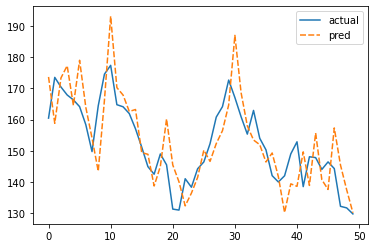

In [41]:
output = pd.DataFrame({'actual': np.array(y_trformed), 'pred': np.array(pred_trformed)})

sns.lineplot(data=output)

Feature: Open(t-4), Score: 0.3823573452
Feature: Open(t-3), Score: 0.0185579600
Feature: Open(t-2), Score: 0.0206135828
Feature: Open(t-1), Score: -0.2299717497
Feature: Open(t), Score: 0.2027630536
Feature: High(t-4), Score: -0.4075930779
Feature: High(t-3), Score: -0.4118133222
Feature: High(t-2), Score: -0.0498625522
Feature: High(t-1), Score: -0.0464232908
Feature: High(t), Score: -0.6373340166
Feature: Low(t-4), Score: -0.5331126358
Feature: Low(t-3), Score: 0.0641415244
Feature: Low(t-2), Score: 0.2880986733
Feature: Low(t-1), Score: 0.0989294836
Feature: Low(t), Score: -0.5843080737
Feature: Close_x(t-4), Score: -0.2202841658
Feature: Close_x(t-3), Score: 0.3698025485
Feature: Close_x(t-2), Score: -0.0659568810
Feature: Close_x(t-1), Score: 0.0743362233
Feature: Close_x(t), Score: 1.7430818817
Feature: Close_y(t-4), Score: 0.5555752579
Feature: Close_y(t-3), Score: -0.2573501966
Feature: Close_y(t-2), Score: 0.2195246546
Feature: Close_y(t-1), Score: 0.2002085300
Feature: Close_

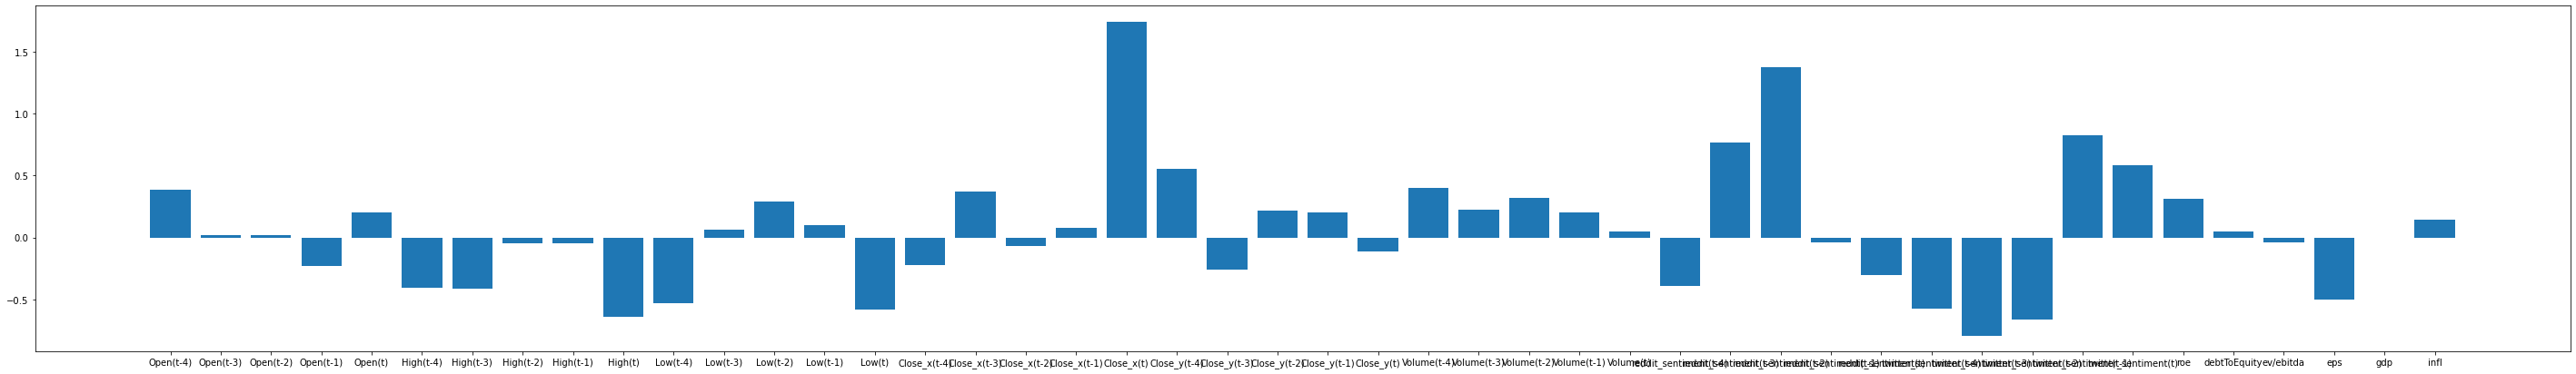

In [42]:
# get importance
importance = best_model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print(f'Feature: {col_order[i]}, Score: {v:.10f}')
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([col_order[x] for x in range(len(importance))], importance)
plt.show()

Feature: Open, Score: 0.3943201918
Feature: High, Score: -1.5530262598
Feature: Low, Score: -0.6662510282
Feature: Close_x, Score: 1.9009796068
Feature: Close_y, Score: 0.6016307617
Feature: Volume, Score: 1.1966476443
Feature: reddit_sentiment, Score: 1.4066910604
Feature: twitter_sentiment, Score: -0.6193589817
Feature: roe, Score: 0.3152257224
Feature: debtToEquity, Score: 0.0479830147
Feature: ev/ebitda, Score: -0.0374796788
Feature: eps, Score: -0.4980377710
Feature: gdp, Score: -0.0000394553
Feature: infl, Score: 0.1443850838


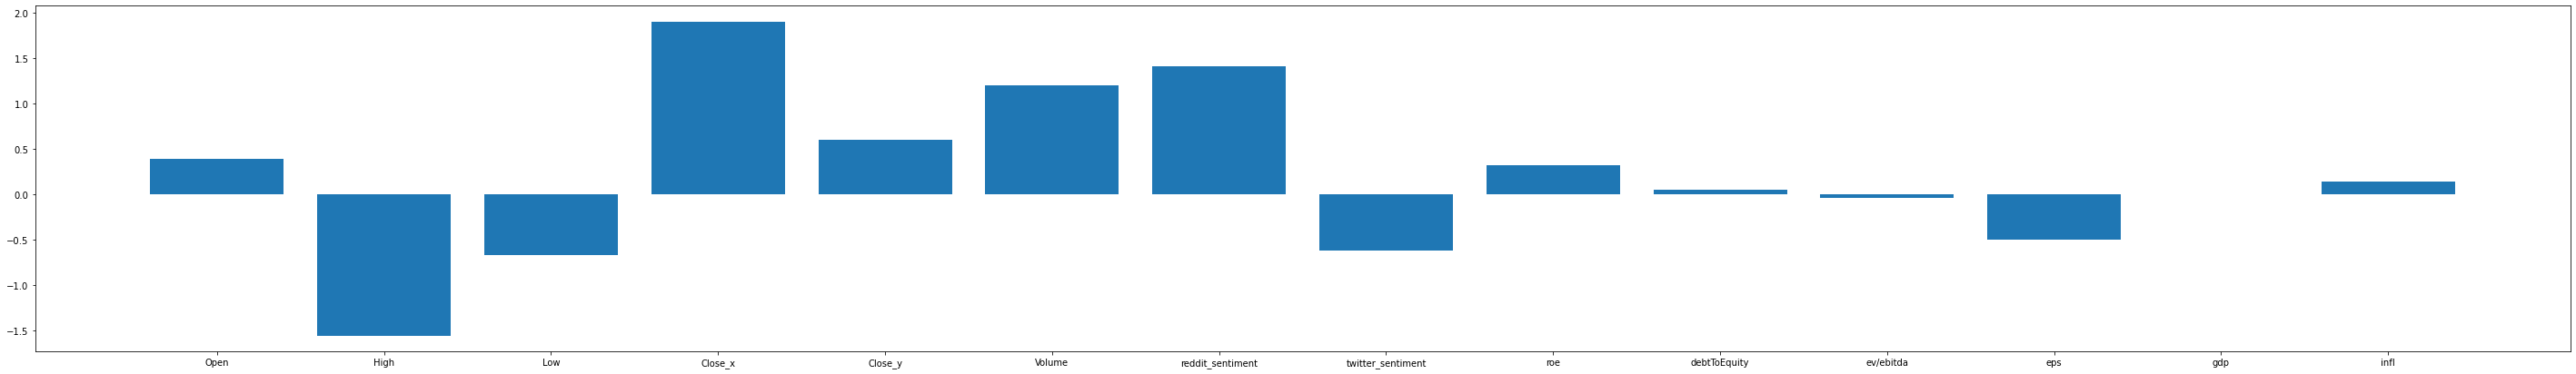

In [43]:
# get importance
importance = best_model.coef_

cols = ['Open', 'High', 'Low', 'Close_x', 'Close_y', 'Volume', 'reddit_sentiment', 'twitter_sentiment','roe', 'debtToEquity','ev/ebitda', 'eps', 'gdp', 'infl']

agg_impt = []
cur = 0
cur_var = 'Open'
at = 0
for i,v in enumerate(importance):
    if (col_order[i].find(cur_var) > -1):
        cur += v
    else: 
        agg_impt.append(cur)
        print(f'Feature: {cols[at]}, Score: {cur:.10f}')
        at += 1
        cur_var = cols[at]
        cur = v
agg_impt.append(cur)
print(f'Feature: {cols[-1]}, Score: {cur:.10f}')
 
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([cols[x] for x in range(len(cols))], agg_impt)
plt.show()

### Random Forest Feature Importance

In [44]:
from sklearn.ensemble import RandomForestRegressor

best_model = RandomForestRegressor()
best_model.fit(X_train, y_train)

RandomForestRegressor()

In [45]:
pred = best_model.predict(X_test)
pred_trformed = [pred[x - y_test.index[0]] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]
y_trformed =  [y[x] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]

mae = mean_absolute_error(y_trformed, pred_trformed)
mse = mean_squared_error(y_trformed, pred_trformed)
rmse = mean_squared_error(y_trformed, pred_trformed, squared=False)
r2 = r2_score(y_trformed, pred_trformed)
score_df.loc[len(score_df)] = ['past5_RF', mae, mse, rmse]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)    

Mean Absolute Error: 7.539831772042164
Mean Squared Error: 77.8738757160163
Root Mean Squared Error: 8.824617596021728
R-squared: 0.5027002913883815


<AxesSubplot:>

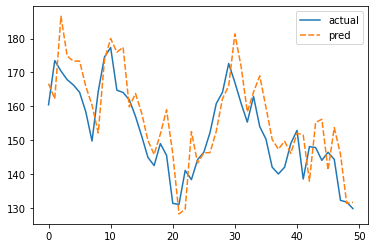

In [46]:
output = pd.DataFrame({'actual': np.array(y_trformed), 'pred': np.array(pred_trformed)})

sns.lineplot(data=output)

Feature: Open(t-4), Score: 0.0025724230
Feature: Open(t-3), Score: 0.0118461788
Feature: Open(t-2), Score: 0.0109186549
Feature: Open(t-1), Score: 0.0103663446
Feature: Open(t), Score: 0.0040383214
Feature: High(t-4), Score: 0.0059435464
Feature: High(t-3), Score: 0.0146088982
Feature: High(t-2), Score: 0.0230996684
Feature: High(t-1), Score: 0.0084441394
Feature: High(t), Score: 0.0077692405
Feature: Low(t-4), Score: 0.0038333214
Feature: Low(t-3), Score: 0.0169199486
Feature: Low(t-2), Score: 0.0073984100
Feature: Low(t-1), Score: 0.0090683903
Feature: Low(t), Score: 0.0483773455
Feature: Close_x(t-4), Score: 0.0119039657
Feature: Close_x(t-3), Score: 0.0266701061
Feature: Close_x(t-2), Score: 0.0091992059
Feature: Close_x(t-1), Score: 0.0058009092
Feature: Close_x(t), Score: 0.3597126647
Feature: Close_y(t-4), Score: 0.0032260543
Feature: Close_y(t-3), Score: 0.0080968607
Feature: Close_y(t-2), Score: 0.0230997829
Feature: Close_y(t-1), Score: 0.0084633989
Feature: Close_y(t), Score

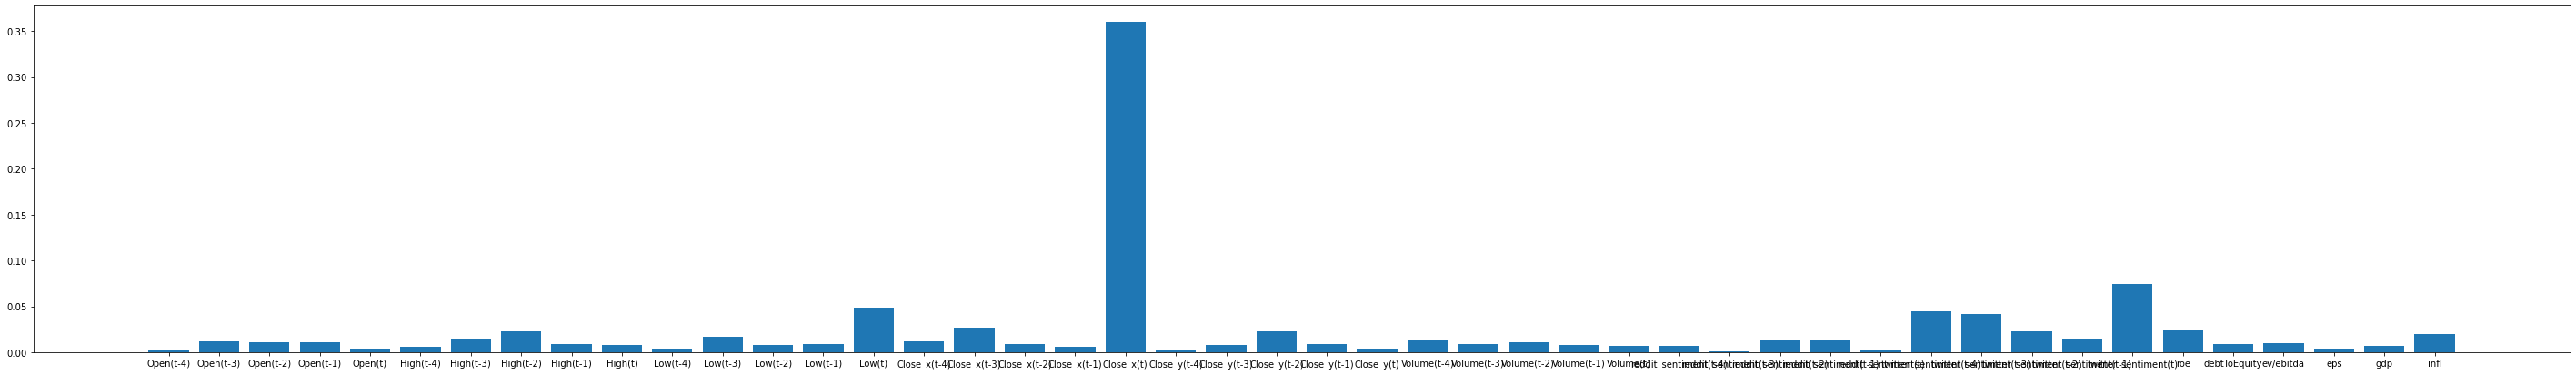

In [47]:
# get importance
importance = best_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print(f'Feature: {col_order[i]}, Score: {v:.10f}')
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([col_order[x] for x in range(len(importance))], importance)
plt.show()

Feature: Open, Score: 0.0397419228
Feature: High, Score: 0.0598654929
Feature: Low, Score: 0.0855974158
Feature: Close_x, Score: 0.4132868517
Feature: Close_y, Score: 0.0468366780
Feature: Volume, Score: 0.0475700163
Feature: reddit_sentiment, Score: 0.0373958543
Feature: twitter_sentiment, Score: 0.1972372406
Feature: roe, Score: 0.0240831024
Feature: debtToEquity, Score: 0.0090752847
Feature: ev/ebitda, Score: 0.0100467516
Feature: eps, Score: 0.0034167874
Feature: gdp, Score: 0.0063524793
Feature: infl, Score: 0.0194941223


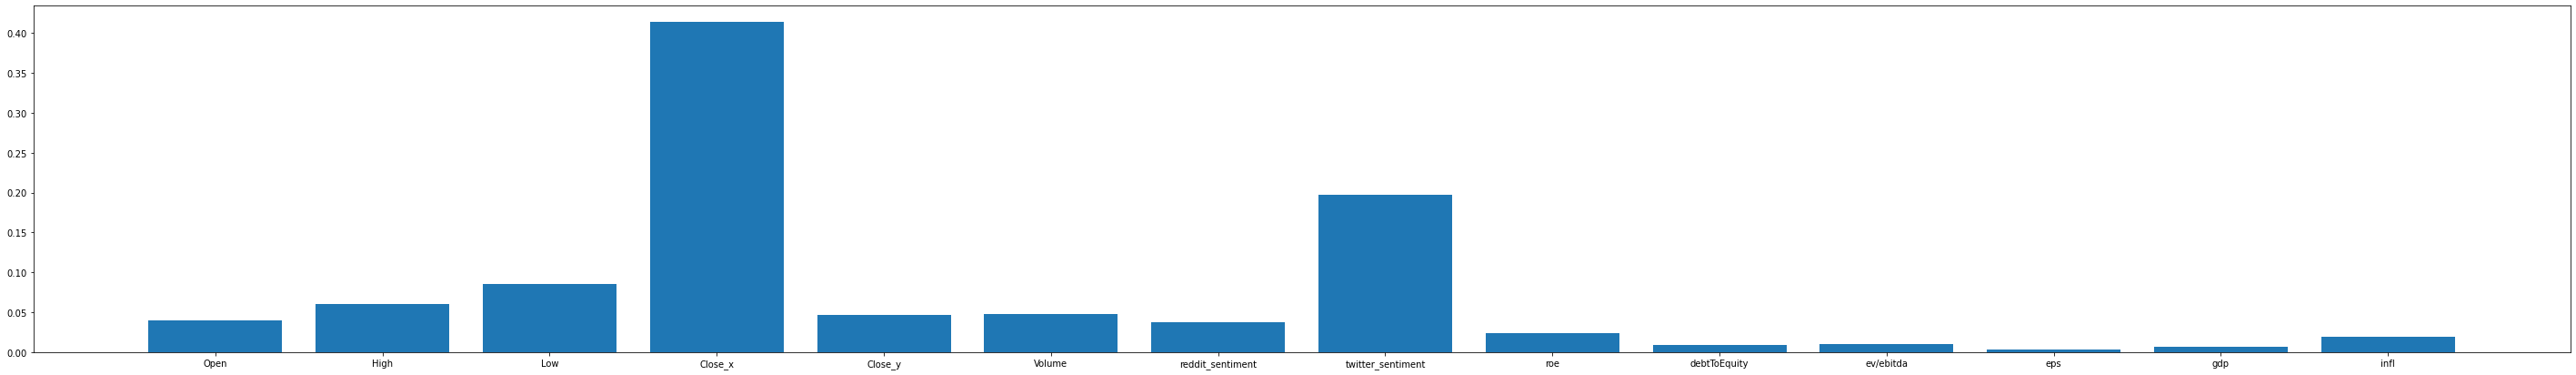

In [48]:
# get importance
importance = best_model.feature_importances_

cols = ['Open', 'High', 'Low', 'Close_x', 'Close_y', 'Volume', 'reddit_sentiment', 'twitter_sentiment','roe', 'debtToEquity','ev/ebitda', 'eps', 'gdp', 'infl']

agg_impt = []
cur = 0
cur_var = 'Open'
at = 0
for i,v in enumerate(importance):
    if (col_order[i].find(cur_var) > -1):
        cur += v
    else: 
        agg_impt.append(cur)
        print(f'Feature: {cols[at]}, Score: {cur:.10f}')
        at += 1
        cur_var = cols[at]
        cur = v
agg_impt.append(cur)
print(f'Feature: {cols[-1]}, Score: {cur:.10f}')
 
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([cols[x] for x in range(len(cols))], agg_impt)
plt.show()

### XGBoost Regression Feature Importance

In [49]:
from xgboost import XGBRegressor

best_model = XGBRegressor()
best_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [50]:
pred = best_model.predict(X_test)
pred_trformed = [pred[x - y_test.index[0]] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]
y_trformed =  [y[x] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]

mae = mean_absolute_error(y_trformed, pred_trformed)
mse = mean_squared_error(y_trformed, pred_trformed)
rmse = mean_squared_error(y_trformed, pred_trformed, squared=False)
r2 = r2_score(y_trformed, pred_trformed)
score_df.loc[len(score_df)] = ['past5_XGB', mae, mse, rmse]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)    

Mean Absolute Error: 7.7812891124676025
Mean Squared Error: 91.84692055019804
Root Mean Squared Error: 9.583679906497192
R-squared: 0.41346894055904937


<AxesSubplot:>

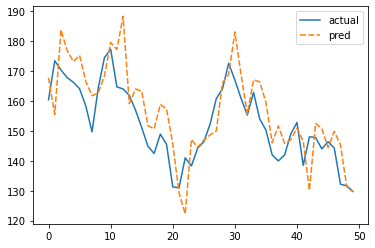

In [51]:
output = pd.DataFrame({'actual': np.array(y_trformed), 'pred': np.array(pred_trformed)})

sns.lineplot(data=output)

Feature: Open(t-4), Score: 0.0038097973
Feature: Open(t-3), Score: 0.0100454530
Feature: Open(t-2), Score: 0.0059332200
Feature: Open(t-1), Score: 0.0085694157
Feature: Open(t), Score: 0.0070455670
Feature: High(t-4), Score: 0.0156167606
Feature: High(t-3), Score: 0.0091213137
Feature: High(t-2), Score: 0.0209605135
Feature: High(t-1), Score: 0.0040042261
Feature: High(t), Score: 0.0018363438
Feature: Low(t-4), Score: 0.0022965260
Feature: Low(t-3), Score: 0.0227923580
Feature: Low(t-2), Score: 0.0091341184
Feature: Low(t-1), Score: 0.0126918349
Feature: Low(t), Score: 0.0417308249
Feature: Close_x(t-4), Score: 0.0203470346
Feature: Close_x(t-3), Score: 0.0028345245
Feature: Close_x(t-2), Score: 0.0080169607
Feature: Close_x(t-1), Score: 0.0003001470
Feature: Close_x(t), Score: 0.5083298683
Feature: Close_y(t-4), Score: 0.0006765200
Feature: Close_y(t-3), Score: 0.0010016336
Feature: Close_y(t-2), Score: 0.0265085083
Feature: Close_y(t-1), Score: 0.0024236068
Feature: Close_y(t), Score

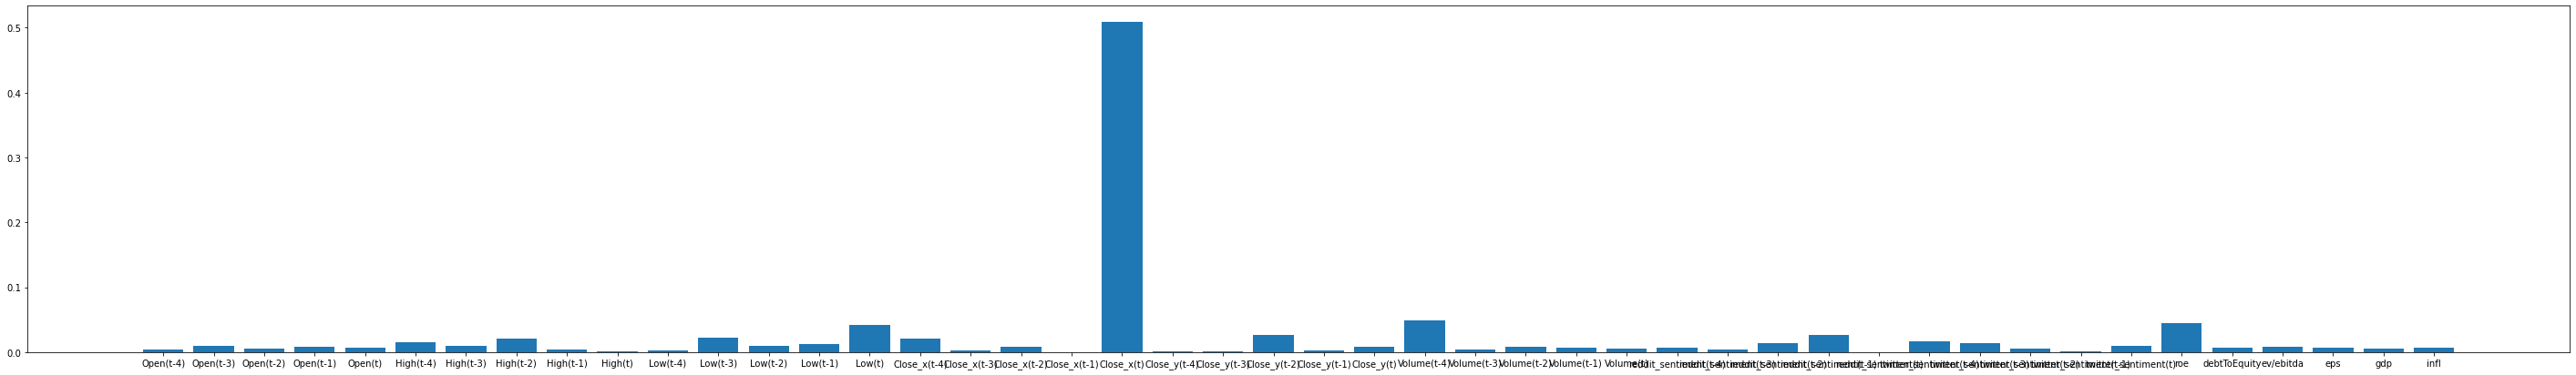

In [52]:
# get importance
importance = best_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print(f'Feature: {col_order[i]}, Score: {v:.10f}')
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([col_order[x] for x in range(len(importance))], importance)
plt.show()

Feature: Open, Score: 0.0354034530
Feature: High, Score: 0.0515391566
Feature: Low, Score: 0.0886456668
Feature: Close_x, Score: 0.5398285389
Feature: Close_y, Score: 0.0386689119
Feature: Volume, Score: 0.0720590577
Feature: reddit_sentiment, Score: 0.0494424254
Feature: twitter_sentiment, Score: 0.0474110320
Feature: roe, Score: 0.0441982709
Feature: debtToEquity, Score: 0.0071125035
Feature: ev/ebitda, Score: 0.0078584803
Feature: eps, Score: 0.0063176318
Feature: gdp, Score: 0.0048495322
Feature: infl, Score: 0.0066653560


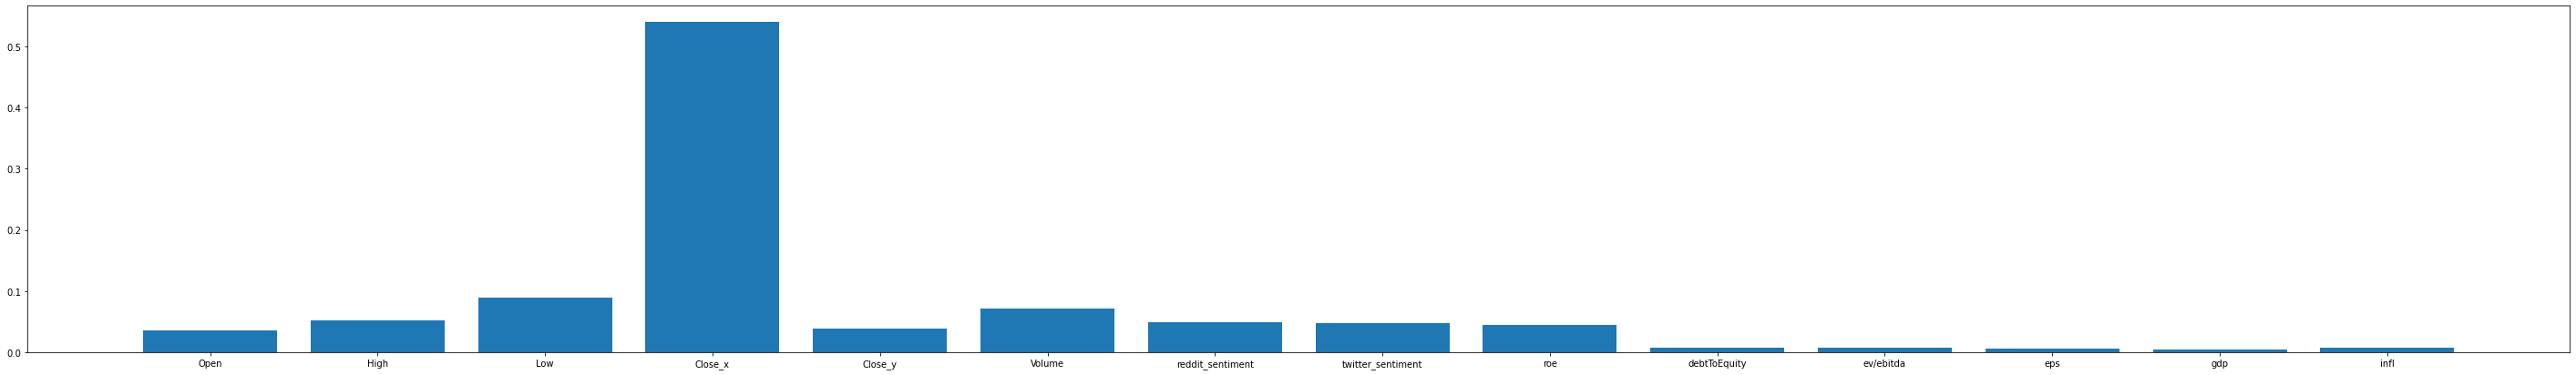

In [53]:
# get importance
importance = best_model.feature_importances_

cols = ['Open', 'High', 'Low', 'Close_x', 'Close_y', 'Volume', 'reddit_sentiment', 'twitter_sentiment','roe', 'debtToEquity','ev/ebitda', 'eps', 'gdp', 'infl']

agg_impt = []
cur = 0
cur_var = 'Open'
at = 0
for i,v in enumerate(importance):
    if (col_order[i].find(cur_var) > -1):
        cur += v
    else: 
        agg_impt.append(cur)
        print(f'Feature: {cols[at]}, Score: {cur:.10f}')
        at += 1
        cur_var = cols[at]
        cur = v
agg_impt.append(cur)
print(f'Feature: {cols[-1]}, Score: {cur:.10f}')
 
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([cols[x] for x in range(len(cols))], agg_impt)
plt.show()

## Sentiment Only

In [54]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close_x', 'Volume', 'Close_y', 'roe',
       'debtToEquity', 'ev/ebitda', 'eps', 'gdp', 'infl', 'dateStr',
       'reddit_sentiment', 'twitter_sentiment'],
      dtype='object')

In [55]:
final_data = data.copy()[['Close_x','reddit_sentiment', 'twitter_sentiment']]
train_df = series_to_supervised(final_data, 'Close_x',[], 5, 1)

In [56]:
train_df['change'] = train_df['Close_x1(t+1)'] - train_df['Close_x(t)']

In [57]:
x = train_df.drop(columns=['Close_x1(t+1)', 'change','Close_x(t)', 'Close_x(t-4)', 'Close_x(t-3)', 'Close_x(t-2)', 'Close_x(t-1)'], axis=1)
y = train_df['change']

In [58]:
# Take last 50 days as test data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=88, shuffle=False)

In [59]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [60]:
from sklearn.linear_model import LinearRegression

best_model = LinearRegression().fit(X_train, y_train)

In [61]:
pred = best_model.predict(X_test)
outcome_df = train_df.iloc[153:].copy()
outcome_df['outcome'] = outcome_df['Close_x(t)'] + pred

mae = mean_absolute_error(outcome_df['Close_x1(t+1)'], outcome_df['outcome'])
mse = mean_squared_error(outcome_df['Close_x1(t+1)'],  outcome_df['outcome'])
rmse = mean_squared_error(outcome_df['Close_x1(t+1)'],  outcome_df['outcome'], squared=False)
r2 = r2_score(outcome_df['Close_x1(t+1)'], outcome_df['outcome'])
score_df.loc[len(score_df)] = ['sentiment', mae, mse, rmse]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)    

Mean Absolute Error: 6.022055692547829
Mean Squared Error: 53.788218815052815
Root Mean Squared Error: 7.3340451876882256
R-squared: 0.6651659604929623


<AxesSubplot:>

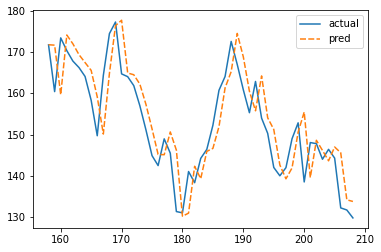

In [62]:
output = pd.DataFrame({'actual': outcome_df['Close_x1(t+1)'], 'pred': outcome_df['outcome']})
sns.lineplot(data=output)

Feature: reddit_sentiment(t-4), Score: -4.581913399405451059465121943504
Feature: twitter_sentiment(t-4), Score: -6.521758458926062651528354763286
Feature: reddit_sentiment(t-3), Score: 1.030315609864881354340582220175
Feature: twitter_sentiment(t-3), Score: -4.630349048799134337173200037796
Feature: reddit_sentiment(t-2), Score: 2.262371468034053201279220957076
Feature: twitter_sentiment(t-2), Score: 3.770988736319618173098433544510
Feature: reddit_sentiment(t-1), Score: 1.629201512677722618605002935510
Feature: twitter_sentiment(t-1), Score: 3.954350490704404919029002485331
Feature: reddit_sentiment(t), Score: 0.420415381498087548095554666361
Feature: twitter_sentiment(t), Score: 4.802788342149156619598215911537


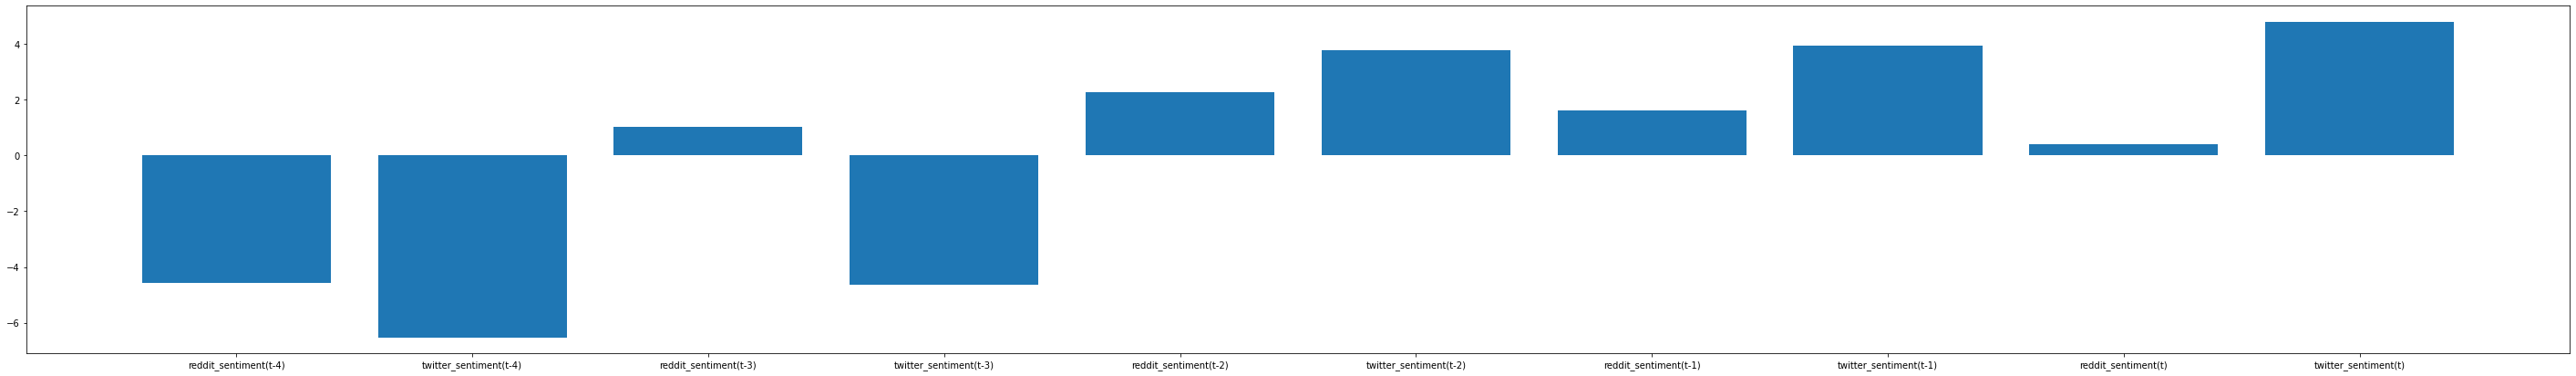

In [63]:
# get importance
importance = best_model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print(f'Feature: {X_train.columns[i]}, Score: {v:.30f}')
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([X_train.columns[y] for y in range(len(importance))], importance)
plt.show()

### Price + Sentiment

In [64]:
final_data = data.copy()[['Close_x', 'Close_y' ,'reddit_sentiment', 'twitter_sentiment']]
train_df = series_to_supervised(final_data, 'Close_x',[], 5, 1)

In [65]:
train_df.columns

Index(['Close_x(t-4)', 'Close_y(t-4)', 'reddit_sentiment(t-4)',
       'twitter_sentiment(t-4)', 'Close_x(t-3)', 'Close_y(t-3)',
       'reddit_sentiment(t-3)', 'twitter_sentiment(t-3)', 'Close_x(t-2)',
       'Close_y(t-2)', 'reddit_sentiment(t-2)', 'twitter_sentiment(t-2)',
       'Close_x(t-1)', 'Close_y(t-1)', 'reddit_sentiment(t-1)',
       'twitter_sentiment(t-1)', 'Close_x(t)', 'Close_y(t)',
       'reddit_sentiment(t)', 'twitter_sentiment(t)', 'Close_x1(t+1)'],
      dtype='object')

In [66]:
cols_series = ['Close_x', 'Close_y', 'reddit_sentiment', 'twitter_sentiment']
cols_unival = ['Close_x1(t+1)']

In [67]:
col_order = []
cur = pd.Series(train_df.columns)

for col in cols_series:
    filtered = list(cur[cur.str.startswith(col)])
    if (col == 'Close_x'):
        filtered.remove('Close_x1(t+1)')
    col_order.extend(filtered)

col_order.extend(cols_unival)

In [68]:
train_df = train_df[col_order]

In [69]:
train_scaled = train_df.copy()
train_scaled = train_scaled.reset_index().drop('index', axis=1)

In [70]:
trform_list = {}

In [71]:
def minmaxscalerAdjust(index, row, in_size, num_var, position):
    trform_dict = {}
    trformed_row = []
    value = 0
    for i in range(num_var):
        cur = np.array(row[ i*in_size : (i+1)*in_size ])
        rowmaxmin = cur.max() - cur.min()
        print('rowmaxmin', rowmaxmin)
        rowmin = cur.min()
        print('rowmin', rowmin)
        trform_dict[i] = [rowmaxmin, rowmin]
        trform_list[index] = trform_dict
        cur = [ (x - rowmin) / (rowmaxmin) for x in cur]
        trformed_row.extend(cur)
        if (i == position):
            target = row[-1]
            value = (target - rowmin) / rowmaxmin
    
    rest = np.array(row[ num_var*in_size : -1 ])
    trformed_row.extend(rest)
    trformed_row.append(value)
    return trformed_row

In [72]:
for index, row in train_scaled.iterrows():
    trformed_row = minmaxscalerAdjust(index, row, 5, 2,0)
    train_scaled.loc[index] = trformed_row

rowmaxmin 5.6183929443359375
rowmin 35.640193939208984
rowmaxmin 175.18017578125
rowmin 2549.68994140625
rowmaxmin 5.119674682617195
rowmin 36.13891220092773
rowmaxmin 142.260009765625
rowmin 2582.610107421875
rowmaxmin 3.601837158203125
rowmin 37.6567497253418
rowmaxmin 131.75
rowmin 2643.85009765625
rowmaxmin 4.499824523925781
rowmin 37.6567497253418
rowmaxmin 152.260009765625
rowmin 2643.85009765625
rowmaxmin 1.7284507751464915
rowmin 40.82010269165039
rowmaxmin 86.31005859375
rowmin 2709.800048828125
rowmaxmin 2.4664306640625
rowmin 40.82010269165039
rowmaxmin 86.31005859375
rowmin 2709.800048828125
rowmaxmin 4.258480072021477
rowmin 41.23471832275391
rowmaxmin 57.33984375
rowmin 2775.60009765625
rowmaxmin 3.5108375549316406
rowmin 42.15657424926758
rowmaxmin 49.639892578125
rowmin 2783.300048828125
rowmaxmin 3.7237625122070312
rowmin 42.54855346679688
rowmaxmin 83.889892578125
rowmin 2783.300048828125
rowmaxmin 5.1295318603515625
rowmin 43.28653335571289
rowmaxmin 112.469970703125

rowmin 149.71307373046875
rowmaxmin 402.41015625
rowmin 4173.10986328125
rowmaxmin 27.652496337890625
rowmin 149.71307373046875
rowmaxmin 409.5302734375
rowmin 4173.10986328125
rowmaxmin 27.652496337890625
rowmin 149.71307373046875
rowmaxmin 409.5302734375
rowmin 4173.10986328125
rowmaxmin 13.28948974609375
rowmin 164.07608032226562
rowmaxmin 190.9501953125
rowmin 4391.68994140625
rowmaxmin 15.46630859375
rowmin 161.89926147460938
rowmaxmin 286.52001953125
rowmin 4296.1201171875
rowmaxmin 20.356689453125
rowmin 157.00888061523438
rowmaxmin 427.26025390625
rowmin 4155.3798828125
rowmaxmin 13.607574462890625
rowmin 151.1444091796875
rowmaxmin 421.289794921875
rowmin 3991.239990234375
rowmaxmin 19.199859619140625
rowmin 144.876220703125
rowmaxmin 400.449951171875
rowmin 3991.239990234375
rowmaxmin 19.441970825195312
rowmin 142.45729064941406
rowmaxmin 322.3701171875
rowmin 3973.75
rowmaxmin 14.551589965820312
rowmin 142.45729064941406
rowmaxmin 184.490234375
rowmin 3973.75
rowmaxmin 8.687

In [73]:
x = train_scaled.drop('Close_x1(t+1)', axis=1)
y = train_scaled['Close_x1(t+1)']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=88, shuffle=False)

In [75]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [76]:
from sklearn.linear_model import LinearRegression

best_model = LinearRegression().fit(X_train, y_train)

In [77]:
pred = best_model.predict(X_test)
pred_trformed = [pred[x - y_test.index[0]] * trform_list[x][0][0] + trform_list[x][0][1] for x in y_test.index]
y_trformed =  [y[x] * trform_list[x][0][0] + trform_list[x][0][1] for x in y_test.index]

mae = mean_absolute_error(y_trformed, pred_trformed)
mse = mean_squared_error(y_trformed, pred_trformed)
rmse = mean_squared_error(y_trformed, pred_trformed, squared=False)
r2 = r2_score(y_trformed, pred_trformed)
score_df.loc[len(score_df)] = ['price+sentiment_LR', mae, mse, rmse]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)    

Mean Absolute Error: 7.370912769687831
Mean Squared Error: 71.99969048236655
Root Mean Squared Error: 8.48526313571751
R-squared: 0.551798744435826


<AxesSubplot:>

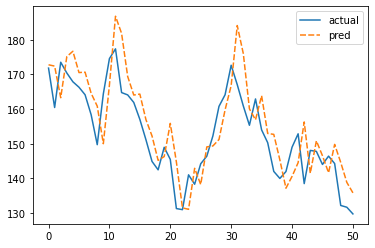

In [78]:
output = pd.DataFrame({'actual': np.array(y_trformed), 'pred': np.array(pred_trformed)})

sns.lineplot(data=output)

In [79]:
score_df

,vars,mae,mse,rmse
0,past10_LR,13.323258,252.087414,15.877261
1,past5_LR,7.789253,85.589096,9.251437
2,past5_RF,7.539832,77.873876,8.824618
3,past5_XGB,7.781289,91.846921,9.583680
4,sentiment,6.022056,53.788219,7.334045
5,price+sentiment_LR,7.370913,71.999690,8.485263


In [80]:
# # get importance
# importance = best_model.coef_

# cols = [ 'Close_x', 'Close_y','reddit_sentiment', 'twitter_sentiment']

# agg_impt = []
# cur = 0
# cur_var = 'Open'
# at = 0
# for i,v in enumerate(importance):
#     if (col_order[i].find(cur_var) > -1):
#         cur += v
#     else: 
#         agg_impt.append(cur)
#         print(f'Feature: {cols[at]}, Score: {cur:.10f}')
#         at += 1
#         cur_var = cols[at]
#         cur = v
# agg_impt.append(cur)
# print(f'Feature: {cols[-1]}, Score: {cur:.10f}')
 
# # plot feature importance
# fig = plt.figure(figsize=(50,7))
# plt.bar([cols[x] for x in range(len(cols))], agg_impt)
# plt.show()

## Model (Price only)

In [108]:
final_data = data.copy()[['Close_x', 'Close_y' ,'reddit_sentiment', 'twitter_sentiment']]
train_eda = series_to_supervised(final_data, 'Close_x',[], 5, 1).reset_index()

In [109]:
from sklearn.preprocessing import MinMaxScaler

scalerPrice = MinMaxScaler()
scalerSentimentT = MinMaxScaler()
scalerSentimentR = MinMaxScaler()
scalerIndexPrice = MinMaxScaler()

In [110]:
train_eda.columns

Index(['index', 'Close_x(t-4)', 'Close_y(t-4)', 'reddit_sentiment(t-4)',
       'twitter_sentiment(t-4)', 'Close_x(t-3)', 'Close_y(t-3)',
       'reddit_sentiment(t-3)', 'twitter_sentiment(t-3)', 'Close_x(t-2)',
       'Close_y(t-2)', 'reddit_sentiment(t-2)', 'twitter_sentiment(t-2)',
       'Close_x(t-1)', 'Close_y(t-1)', 'reddit_sentiment(t-1)',
       'twitter_sentiment(t-1)', 'Close_x(t)', 'Close_y(t)',
       'reddit_sentiment(t)', 'twitter_sentiment(t)', 'Close_x1(t+1)'],
      dtype='object')

In [111]:
train_eda.loc[0, 'price_wo_seasonality' ] = 0
train_eda.loc[0, 'iprice_wo_seasonality'] = 0
for index, row in train_eda.iloc[1:].iterrows():
    train_eda.loc[index,'price_wo_seasonality'] = train_eda.loc[index, 'Close_x(t)'] - train_eda.loc[index-1, 'Close_x(t)']
    train_eda.loc[index,'iprice_wo_seasonality'] = train_eda.loc[index, 'Close_y(t)'] - train_eda.loc[index-1, 'Close_y(t)']

In [112]:
train_eda['price_wo_seasonality'] = [x[0] for x in scalerPrice.fit_transform(np.array(train_eda['price_wo_seasonality']).reshape(-1,1))]

In [113]:
train_eda['iprice_wo_seasonality'] = [x[0] for x in scalerPrice.fit_transform(np.array(train_eda['iprice_wo_seasonality']).reshape(-1,1))]

In [114]:
train_eda['twitter_sentiment(t)'] = [x[0] for x in scalerSentimentT.fit_transform(np.array(train_eda['twitter_sentiment(t)']).reshape(-1,1))]

In [115]:
train_eda['reddit_sentiment(t)'] = [x[0] for x in scalerSentimentR.fit_transform(np.array(train_eda['reddit_sentiment(t)']).reshape(-1,1))]

<AxesSubplot:>

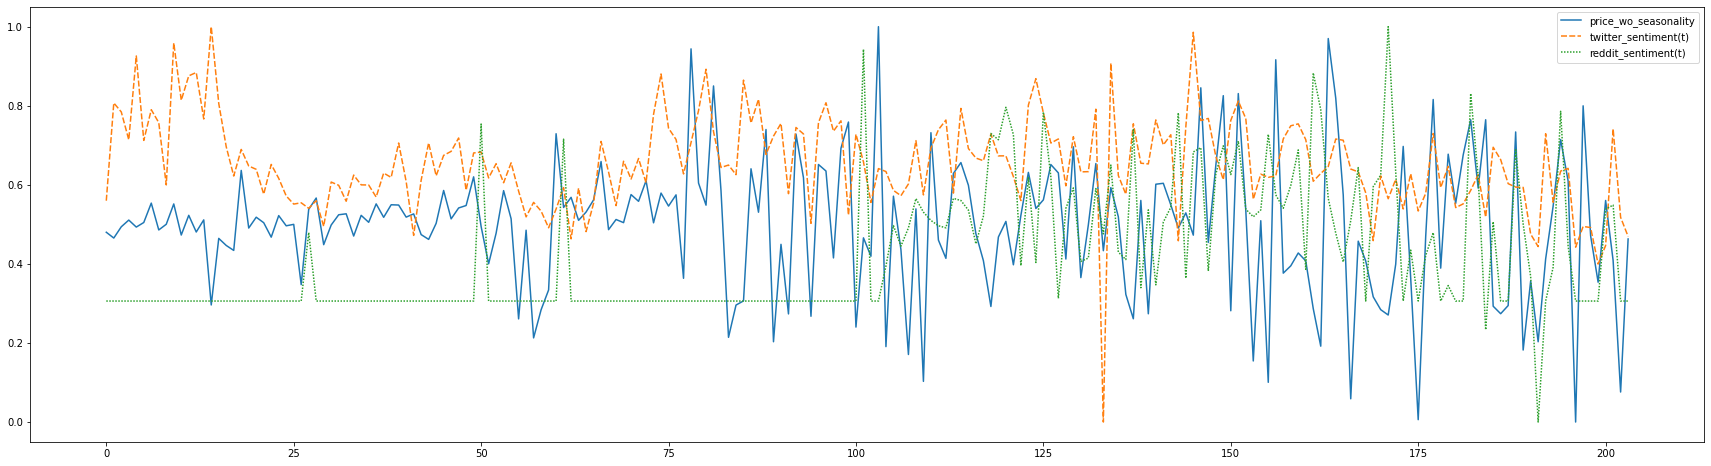

In [116]:
fig = plt.figure(figsize=(30, 8))
sns.lineplot(data=train_eda[['price_wo_seasonality','twitter_sentiment(t)', 'reddit_sentiment(t)']])

<AxesSubplot:>

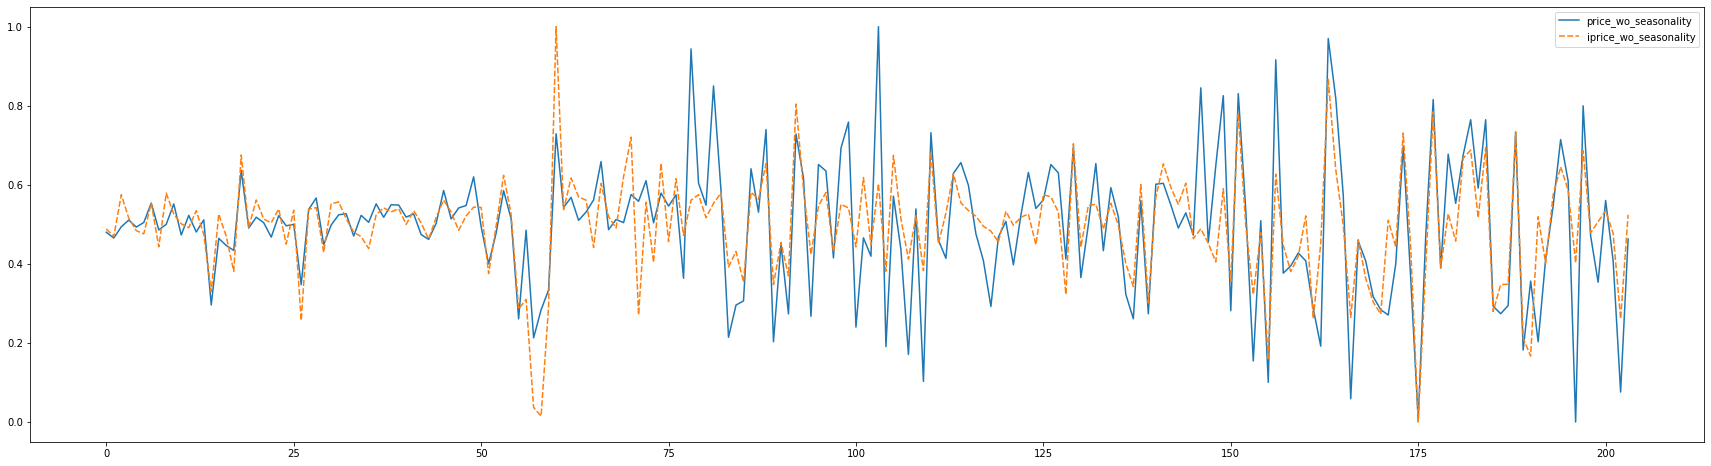

In [117]:
fig = plt.figure(figsize=(30, 8))
sns.lineplot(data=train_eda[['price_wo_seasonality','iprice_wo_seasonality']])